# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib inline
import lightkurve as lk
import gatspy

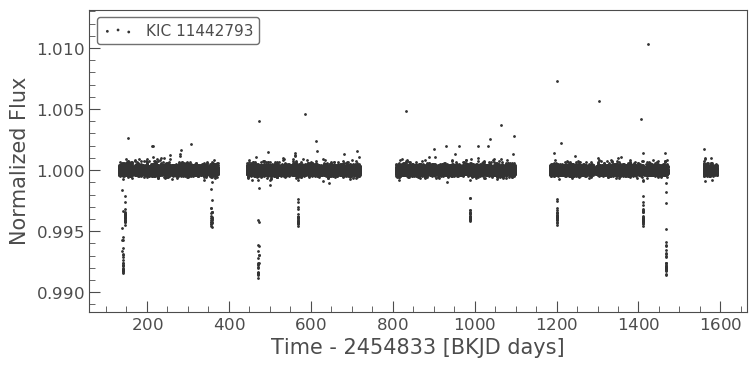

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

### First, we can get a coarse periodogram directly from `lightkurve`. You can use Lomb-Scargle with 5 odd terms but you'll want to build a period grid with variable spacing so you sample the short and long periods efficiently. A common grid size will take a LONG time. Another alternative is to use the box-least squares method instead.

### I'm also using scipy's `find_peaks` routine to pick out a few promising candidates from against the local background:

`period` contains 168704 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


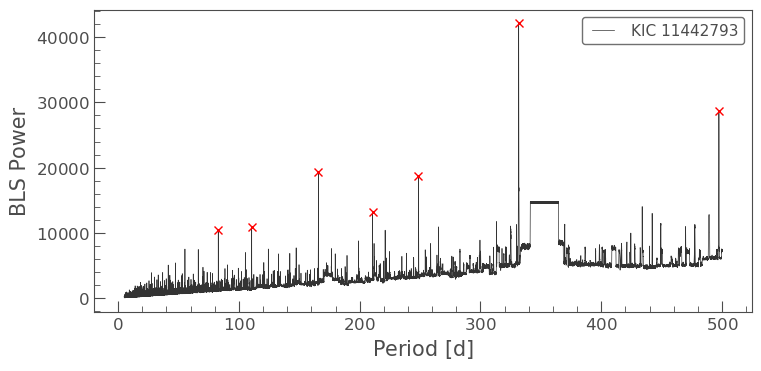

In [3]:
periodogram = clc.to_periodogram(method="bls", period=np.arange(5, 500, .01))
periodogram.plot()

# find peaks is fairly easy to use but the distance argument here is not in time/period steps but integer stepsize
# if you zoom in you'll find many nearby peaks/sidelobes so this just helps filter them out
# height is just from the BLS power plot - pick a threshold that is a reasonable level above the background
from scipy.signal import find_peaks, find_peaks_cwt
peaks, _ = find_peaks(periodogram.power, height=10000, distance=2000)

# exclude detected peak near 365 days - we should probably do this by filtering on period value but meh.
peaks = peaks[(periodogram.period[peaks].value -365 < -10)  |  (periodogram.period[peaks].value - 365 > 120)]


ax = plt.gca()
ax.plot(1./periodogram.frequency[peaks], periodogram.power[peaks], marker='x', color='r', linestyle='None')

In [4]:
candidate_periods = 1./periodogram.frequency[peaks]
candidate_transit_times = periodogram.transit_time[peaks]
candidate_periods


<Quantity [ 82.89, 110.53, 165.78, 210.6 , 248.63, 331.61, 497.39] d>

### Many of these periods are aliases - periods with multiples of 2/3/some integer of the true period

### Generally we see that the shorter periods have less power than the longer periods, so we'll pick the longer periods 

In [5]:
out_periods = []
out_tt = []
for i, period in enumerate(candidate_periods):
    if period in out_periods:
        pass
    test_period_2 = period*2
    test_period_3 = period*3
    print(period, test_period_2, test_period_3)
    
    delta_period_2 = np.abs(candidate_periods - test_period_2)
    delta_period_3 = np.abs(candidate_periods - test_period_3)
    
    if np.any(delta_period_2.value < 0.5) or np.any(delta_period_3.value < 0.5):
        continue
    else:
        out_periods.append(period)
        out_tt.append(candidate_transit_times[i])
out_periods

82.88999999999834 d 165.77999999999668 d 248.669999999995 d
110.52999999999776 d 221.0599999999955 d 331.58999999999327 d
165.77999999999656 d 331.5599999999931 d 497.3399999999897 d
210.59999999999562 d 421.19999999999123 d 631.7999999999869 d
248.6299999999948 d 497.2599999999896 d 745.8899999999844 d
331.609999999993 d 663.219999999986 d 994.829999999979 d
497.3899999999895 d 994.779999999979 d 1492.1699999999687 d


[<Quantity 210.6 d>, <Quantity 331.61 d>, <Quantity 497.39 d>]

Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 10 steps per peak; omega_step = 0.000431
 - User-specified period range:  2.1e+02 to 2.1e+02
 - Computing periods at 2 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 500 steps
Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 10 steps per peak; omega_step = 0.000431
 - User-specified period range:  3.3e+02 to 3.3e+02
 - Computing periods at 2 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 500 steps
Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 10 steps per peak; omega_step = 0.000431
 - User-specified period range:  4.8e+02 to 5e+02
 - Computing periods at 2 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 500 steps


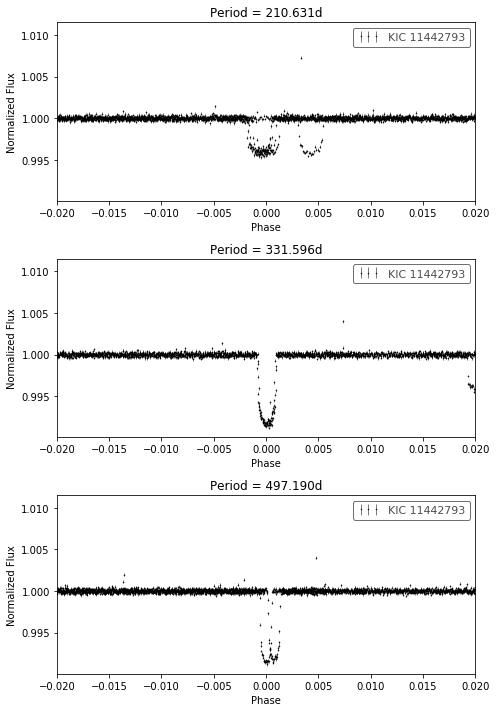

In [6]:
model = gatspy.periodic.LombScargle(fit_period=True, Nterms=31, center_data=False)
phase = np.arange(-0.5, 0.500001, 0.00001)
fig, axs = plt.subplots(nrows=len(out_periods), ncols=1, figsize=(7, 10))

for i, period in enumerate(out_periods):
    period = period.value
    model.optimizer.period_range = (period-1.5, period+1.5)
    model.optimizer.set(first_pass_coverage=10)
    model.fit(clc.time, clc.flux, clc.flux_err)
    best_period = model.best_period
    t0 = out_tt[i]
    ax = axs[i]
    clc.fold(period=best_period, t0=t0).errorbar(ax=ax, marker='.', color='k')
    ax.set_xlim(-0.02, 0.02)
    ax.set_title(f'Period = {best_period:.3f}d')
fig.tight_layout()
    